In [1]:
from __future__ import print_function, division
%pylab notebook
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import brewer2mpl
from matplotlib.pyplot import cm 
from bokeh.plotting import *
output_notebook()

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
df_tags = pd.read_csv('data/ds_urls_shortnames_concepts_reviewed_2016_06_21.csv', encoding='utf-8')
print('len:', len(df_tags))
print('tags count:', df_tags['concept_tag'].count())
df_tags.head(2)

len: 940
tags count: 940


,id,course_shortname,url,concept_tag
0,ud257,ab-testing,https://www.udacity.com/course/ab-testing--ud2...,video_lecture
1,ud257,ab-testing,https://www.udacity.com/course/ab-testing--ud2...,in_depth


In [3]:
df_transs = pd.read_csv('data/learning_resource_w_slide_transcript_2016_07_07.csv', encoding='utf-8')
print('len:', len(df_transs))
df_transs.head(2)

len: 357


,id,title,subtitle,description,short_description,venue,slide_text,transcript_text
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,Udacity,NaN,NaN
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,Udacity,NaN,NaN


In [4]:
df = pd.merge(df_tags, df_transs, on='id', how='outer').groupby(by='id', as_index=False)
merged_df = pd.DataFrame(df.apply(lambda x: x.iloc[0]))
merged_df['tags'] = df.apply(lambda x: map(str, list(x['concept_tag'].values)))
print('len:', len(merged_df))
print('slide text:', merged_df['slide_text'].count())
print('transcript text:', merged_df['transcript_text'].count())
merged_df.head(2)

len: 357
slide text: 186
transcript text: 165


,id,course_shortname,url,concept_tag,title,subtitle,description,short_description,venue,slide_text,transcript_text,tags
0,-4ffSHNYEeWIfhKr_WcYsQ,reproducible-res,http://www.coursera.org/learn/reproducible-res...,reproducibility,Reproducible Research,NaN,This course focuses on the concepts and tools ...,NaN,Coursera,NaN,NaN,"[reproducibility, project, R, in_depth, video_..."
1,-N44X0IJEeWpogr5ZO8qxQ,ml-clust-retrieve,http://www.coursera.org/learn/ml-clustering-an...,natural_language_processing,Machine Learning: Clustering & Retrieval,NaN,Case Studies: Finding Similar Documents\n\nA r...,NaN,Coursera,NaN,NaN,"[natural_language_processing, text_data, high_..."


In [5]:
df = merged_df
no_tags = df['tags'].apply(lambda x: x[0] == 'nan')
print('no tags:', no_tags.sum()/len(df)*100, '%')
df = df[no_tags == 0]
print('tagged resources:', len(df))
df['tags'] = df['tags'].apply(lambda x: [i.lower() for i in x])
df['tags'].head(10)

no tags: 58.5434173669 %
tagged resources: 148


0      [reproducibility, project, r, in_depth, video_...
1      [natural_language_processing, text_data, high_...
2      [video_lecture, project, genomic_data, genetic...
62     [video_lecture, project, regression, economics...
63     [video_lecture, business_analytics, regression...
149    [video_lecture, economics, regression, data_co...
150    [project, video_lecture, project_focused, data...
184    [video_lecture, project, r, in_depth, data_vis...
185    [video_lecture, classification, data_cleaning,...
186    [video_lecture, big_data, hadoop, in_depth, sp...
Name: tags, dtype: object

In [6]:
cols = ['title', 'subtitle', 'description', 'slide_text', 'transcript_text']
df['all-text'] = ''
for i in cols:
    try:
        df['all-text'] += df[i].astype('str')
    except UnicodeEncodeError:
        df['all-text'] += df[i].str.encode('utf-8')        
    df['all-text'] += ' '
df['all-text'].tail(2)

355    Data Warehouse Concepts, Design, and Data Inte...
356    Data Manipulation at Scale: Systems and Algori...
Name: all-text, dtype: object

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm, tqdm_pandas
import string

In [8]:
stemmer = PorterStemmer()
allowed_chars = set(string.ascii_lowercase) | {' '}

def text_cleanup(text):
    #text = str(text)
    #text = text.replace('\n', ' ')
    text = text.lower()
    text = text.replace('videolectures.net', '')
    text = ' '.join((stemmer.stem(i.decode('utf-8')) for i in text.split()))
    text = text.replace('nan', '')
    text = filter(lambda x: x in allowed_chars, text.lower())
    return text
    
df['all-text'] = df['all-text'].apply(text_cleanup)

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.3, min_df=2)
vectorized_text = vectorizer.fit_transform(df['all-text'].values)
from sklearn.decomposition import TruncatedSVD
if True:
    svd = TruncatedSVD(n_components=5, n_iter=100)
    vectorized_text = svd.fit_transform(vectorized_text)
else:
    vectorized_text = vectorized_text
print(type(vectorized_text))
print(vectorized_text.shape)
print(len(vectorized_text.shape))

<type 'numpy.ndarray'>
(148, 5)
2


In [10]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter, defaultdict
import operator

<IPython.core.display.Javascript object>


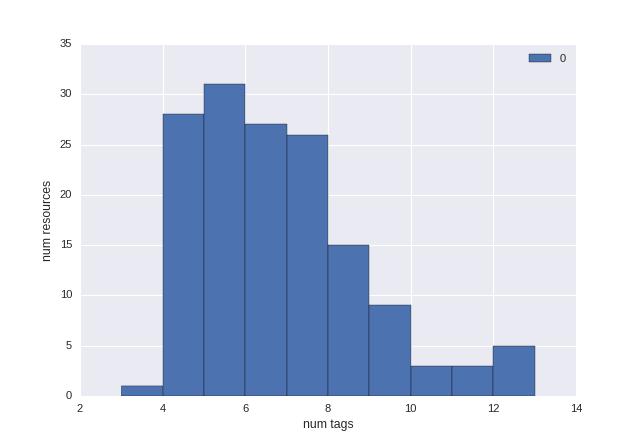

In [11]:
tags = df['tags'].tolist()
pd.DataFrame(map(len, tags)).plot(kind='hist')
plt.xlabel('num tags')
plt.ylabel('num resources')
plt.show()

In [12]:
results = list()
use_distance_weights = False
num_pred_tags = 15
n_neighs = 15
for num_neighs in tqdm(range(1, n_neighs)):
    knn = NearestNeighbors(n_neighbors=num_neighs + 1) # we need one neigh more to prevent validation on training data
    knn.fit(vectorized_text)
    neigh_dist, neighs = knn.kneighbors(vectorized_text, return_distance=True)
    neigh_dist, neighs = neigh_dist[:, 1:], neighs[:, 1:] # exclude itself
    predicted_tags = list()
    for row, row_dist in zip(neighs, neigh_dist):
        if use_distance_weights:
            neigh_tags = [tags[idx] for idx in row]
            dist_dict = defaultdict(float)
            for n_tags, d in zip(neigh_tags, row_dist):
                d = 1./d
                for t in n_tags:
                    dist_dict[t] += d
            neigh_tags = sorted(dist_dict.iteritems(), key=operator.itemgetter(1), reverse=True)
        else:            
            neigh_tags = sorted(Counter([t for idx in row for t in tags[idx]]).iteritems(), key=operator.itemgetter(1), reverse=True)         
        n_tags, n_w = zip(*neigh_tags)
        predicted_tags.append(n_tags[:num_pred_tags])
    eval_df = pd.DataFrame(columns=['y_true'], dtype='object')
    eval_df['y_true'] = map(set, tags)
    for i in range(num_pred_tags):
        eval_df['y_pred_' + str(i)] = ''
        eval_df['y_pred_' + str(i)] = eval_df['y_pred_' + str(i)].astype('object')
        eval_df['y_pred_' + str(i)] = [set(t[:i + 1]) for t in predicted_tags]
        
    res = list()
    res.append(num_neighs)
    for i in range(num_pred_tags):
        t_col = 'y_true'
        p_col = 'y_pred_' + str(i)
                                       
        mean_overlap = (eval_df[[t_col, p_col]].apply(lambda x: len(x[t_col] & x[p_col])/len(x[t_col])*100, axis=1)).mean()
        res.append(mean_overlap)
    # print('', match_in_perc, ' % match')
    results.append(tuple(res))

100%|██████████| 14/14 [00:03<00:00,  3.88it/s]


<IPython.core.display.Javascript object>


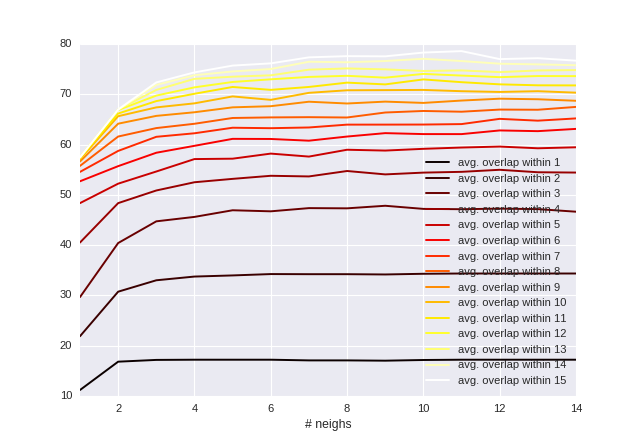

In [13]:
num_res_cols = len(results[0]) - 1
cols = ['# neighs']
cols.extend(['avg. overlap within ' + str(i + 1) for i in range(num_res_cols)])
pd.DataFrame(columns=cols, data=results).plot(x='# neighs', color=cm.hot(np.linspace(0, 1, num_res_cols)))
plt.show()